In [499]:
%load_ext autoreload
%autoreload 2

# To load the environment variable defined in the .env file
from dotenv import load_dotenv
load_dotenv();

import os
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from scipy import ndimage
from scipy import stats
from scipy.ndimage import gaussian_filter 
from sklearn.neighbors import KernelDensity
import seaborn as sns
import plotly.graph_objects as go

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [500]:
season_year = 2019
season_type = "Regular"

In [501]:
import src.data.NHLDataManager as DataManager
data_manager = DataManager.NHLDataManager()

In [502]:
data_season_df = data_manager.get_season_dataframe(season_year=season_year, season_type=season_type)

In [503]:
data_season_df.head(5)

,Game ID,Event Index,Time,Period,Team,Type,Shot Type,Shooter,Goalie,Empty Net,Strength,X,Y,st_X,st_Y
0,2019020001,4,00:25,1,Ottawa Senators (OTT),GOAL,Tip-In,Brady Tkachuk,Frederik Andersen,False,Even,85.0,-1.0,85.0,-1.0
1,2019020001,145,02:20,2,Toronto Maple Leafs (TOR),GOAL,Wrist Shot,Frederik Gauthier,Craig Anderson,False,Even,86.0,0.0,86.0,0.0
2,2019020001,165,04:42,2,Toronto Maple Leafs (TOR),GOAL,Slap Shot,Trevor Moore,Craig Anderson,False,Even,84.0,2.0,84.0,2.0
3,2019020001,172,05:51,2,Ottawa Senators (OTT),GOAL,Wrist Shot,Scott Sabourin,Frederik Andersen,False,Even,-83.0,-6.0,83.0,6.0
4,2019020001,181,08:02,2,Toronto Maple Leafs (TOR),GOAL,Wrist Shot,Auston Matthews,Craig Anderson,False,Even,83.0,5.0,83.0,5.0


In [504]:
total_shots_league = len(data_season_df)
number_of_games = len(data_season_df['Game ID'].unique())
print(f'Total number of shots during season {season_year} ({season_type}) = {total_shots_league}')
print(f'Number of games during season {season_year} ({season_type}) = {number_of_games}')

mean_shots_per_hour = total_shots_league / (2*number_of_games)
print(f'Mean shots by team by hour during season {season_year} ({season_type}) = {mean_shots_per_hour}')

total_goals_league = len(data_season_df[data_season_df['Type'] == 'GOAL'])
mean_goals_per_hour = total_goals_league / (2*number_of_games)
print(f'Mean goals by team by hour during season {season_year} ({season_type}) = {mean_goals_per_hour}')


Total number of shots during season 2019 (Regular) = 68500
Number of games during season 2019 (Regular) = 1082
Mean shots by team by hour during season 2019 (Regular) = 31.6543438077634
Mean goals by team by hour during season 2019 (Regular) = 3.0720887245841033


In [505]:
list_of_teams = data_season_df['Team'].unique()
number_of_teams = len(list_of_teams)

print(f'Number of Teams during season {season_year} ({season_type}) = {number_of_teams}')

Number of Teams during season 2019 (Regular) = 31


In [506]:
# Compute the number of games played for each team. Should be 82, but could be less or maybe even different for each team (COVID etc.)
df_number_of_games_by_team = data_season_df[['Team', 'Game ID']].groupby('Team').describe()['Game ID']['unique']
df_number_of_games_by_team = df_number_of_games_by_team.sort_index(ascending=True)
df_number_of_games_by_team.head()

Team
Anaheim Ducks (ANA)      71
Arizona Coyotes (ARI)    70
Boston Bruins (BOS)      70
Buffalo Sabres (BUF)     69
Calgary Flames (CGY)     70
Name: unique, dtype: object

In [507]:
df_total_shots_season_by_team = data_season_df.groupby('Team').size()
df_total_shots_season_by_team = df_total_shots_season_by_team.sort_index(ascending=True)
df_total_shots_season_by_team.head(5)

Team
Anaheim Ducks (ANA)      2129
Arizona Coyotes (ARI)    2243
Boston Bruins (BOS)      2271
Buffalo Sabres (BUF)     2033
Calgary Flames (CGY)     2232
dtype: int64

In [508]:
data_season_goal = data_season_df.loc[data_season_df['Type'] == 'GOAL']
data_season_goal.groupby('Team').size()
data_season_goal = data_season_goal.sort_index(ascending=True)
data_season_goal.head(5)

# This is pretty consistent with https://www.nhl.com/standings/2021/league

,Game ID,Event Index,Time,Period,Team,Type,Shot Type,Shooter,Goalie,Empty Net,Strength,X,Y,st_X,st_Y
0,2019020001,4,00:25,1,Ottawa Senators (OTT),GOAL,Tip-In,Brady Tkachuk,Frederik Andersen,False,Even,85.0,-1.0,85.0,-1.0
1,2019020001,145,02:20,2,Toronto Maple Leafs (TOR),GOAL,Wrist Shot,Frederik Gauthier,Craig Anderson,False,Even,86.0,0.0,86.0,0.0
2,2019020001,165,04:42,2,Toronto Maple Leafs (TOR),GOAL,Slap Shot,Trevor Moore,Craig Anderson,False,Even,84.0,2.0,84.0,2.0
3,2019020001,172,05:51,2,Ottawa Senators (OTT),GOAL,Wrist Shot,Scott Sabourin,Frederik Andersen,False,Even,-83.0,-6.0,83.0,6.0
4,2019020001,181,08:02,2,Toronto Maple Leafs (TOR),GOAL,Wrist Shot,Auston Matthews,Craig Anderson,False,Even,83.0,5.0,83.0,5.0


In [509]:
df_mean_shots_per_team_by_hour = df_total_shots_season_by_team.sort_index(ascending=True) / df_number_of_games_by_team.sort_index(ascending=True)
print(df_mean_shots_per_team_by_hour.head(5))
# This is pretty consistent with https://www.statmuse.com/nhl/ask?q=nhl+team+stats+shots+per+game+2021-22

Team
Anaheim Ducks (ANA)      29.985915
Arizona Coyotes (ARI)    32.042857
Boston Bruins (BOS)      32.442857
Buffalo Sabres (BUF)     29.463768
Calgary Flames (CGY)     31.885714
dtype: object


In [510]:
x_shots_season = data_season_df['st_X'].to_numpy().copy().astype(np.float32)
y_shots_season = data_season_df['st_Y'].to_numpy().copy().astype(np.float32)

x_nan = np.isnan(x_shots_season)
y_nan = np.isnan(y_shots_season)

x_shots_season = x_shots_season[(~x_nan) & (~y_nan)]
y_shots_season = y_shots_season[(~x_nan) & (~y_nan)]

# mask_defensive = (x_shots_season < 0) & (x_shots_season > 89)
# x_shots_season = x_shots_season[mask_offensive]
# y_shots_season = y_shots_season[mask_offensive]
# x_shots_season[mask_defensive] = 0
# y_shots_season[mask_defensive] = 0

number_of_games = len(data_season_df['Game ID'].unique())

print(f'Number of games in season {season_year} ({season_type}) = {number_of_games}')
print(f'Number of shots from offensive zone in season {season_year} ({season_type}) = {len(x_shots_season)}')

Number of games in season 2019 (Regular) = 1082
Number of shots from offensive zone in season 2019 (Regular) = 66045


In [511]:
print(x_shots_season.mean(), y_shots_season.mean())

print(x_shots_season.shape)
print(y_shots_season.shape)


57.35679 0.08736467
(66045,)
(66045,)


In [512]:
# data_one_team_df = data_season_df.loc[data_season_df['Team'] == "Buffalo Sabres (BUF)"]
data_one_team_df = data_season_df.loc[data_season_df['Team'] == "San Jose Sharks (SJS)"]
# data_one_team_df = data_season_df.loc[data_season_df['Team'] == "Anaheim Ducks (ANA)"]

x_shots_one_team = data_one_team_df['st_X'].to_numpy().copy().astype(np.float32)
y_shots_one_team = data_one_team_df['st_Y'].to_numpy().copy().astype(np.float32)

x_nan = np.isnan(x_shots_one_team)
y_nan = np.isnan(y_shots_one_team)

x_shots_one_team = x_shots_one_team[(~x_nan) & (~y_nan)]
y_shots_one_team = y_shots_one_team[(~x_nan) & (~y_nan)]


# mask_defensive = (x_shots_one_team < 0) & (x_shots_one_team > 89)
# y_shots_season = y_shots_season[mask_offensive]
# x_shots_one_team[mask_defensive] = 0
# x_shots_one_team[mask_defensive] = 0


In [513]:
def get_shots_hist2D(x_shots, y_shots, num_pts_x=20, num_pts_y=20):

    # We are only interested in shots in offensive zone, so we don't care about negative x coordinates
    x_min, x_max = 0.0, 100.
    y_min, y_max = -42.5, 42.5

    delta_x = (x_max-x_min) / num_pts_x
    delta_y = (y_max-y_min) / num_pts_y

    x_grid = np.arange(x_min-delta_x, x_max+delta_x, delta_x)
    y_grid = np.arange(y_min-delta_y, y_max+delta_y, delta_y)

    # ret = stats.binned_statistic_2d(x_shots.tolist(), y_shots.tolist(), None, 'count', bins=[x_grid.tolist(), y_grid.tolist()])
    H, x_edge, y_edge = np.histogram2d(x_shots, y_shots, bins=[x_grid, y_grid])
    
    return H.T, x_edge[1:], y_edge[1:]


In [514]:
shots_hist2D_season, x_bins, y_bins = get_shots_hist2D(x_shots_season, y_shots_season, num_pts_x=20, num_pts_y=20)
print(shots_hist2D_season.sum())
# We lost some shots, but they have benn taken from the defensize zone

64253.0


In [515]:
print(x_bins)
print(y_bins)

[  0.   5.  10.  15.  20.  25.  30.  35.  40.  45.  50.  55.  60.  65.
  70.  75.  80.  85.  90.  95. 100.]
[-42.5  -38.25 -34.   -29.75 -25.5  -21.25 -17.   -12.75  -8.5   -4.25
   0.     4.25   8.5   12.75  17.    21.25  25.5   29.75  34.    38.25
  42.5 ]


In [516]:
shots_hist2D_season, _, _ = get_shots_hist2D(x_shots_season, y_shots_season, num_pts_x=20, num_pts_y=20)
shots_hist2D_season_by_hour = shots_hist2D_season / (number_of_games*2)

shots_hist2D_season_by_hour.sum()

29.691774491682068

In [517]:
np.where(shots_hist2D_season == 0)
# Great, we don't have zero value

(array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  1,  1,  1,  2,  2,  3,  4, 11, 17, 18, 19, 19, 20,
        20, 20]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 18, 19, 20, 19, 20, 20, 20, 20, 20, 20, 19, 20, 18,
        19, 20]))

0.8451940850277264
0.8858595194085028


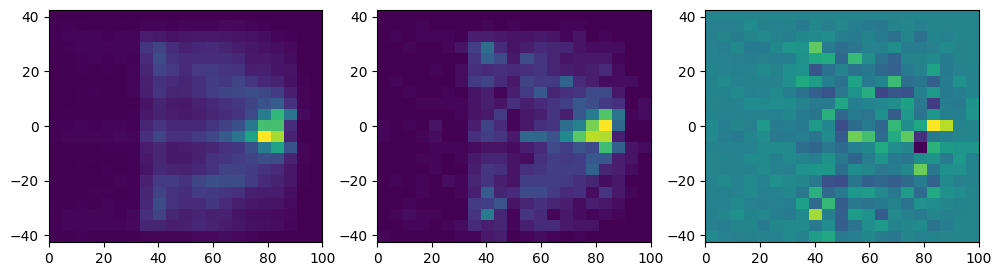

In [518]:
number_of_games_by_team = df_number_of_games_by_team.mean()

shots_hist2D_season, x_edge, y_edge = get_shots_hist2D(x_shots_season, y_shots_season, num_pts_x=20, num_pts_y=20)
shots_hist2D_season_by_hour = shots_hist2D_season / (number_of_games*2)

shots_hist2D_one_team, x_edge, y_edge = get_shots_hist2D(x_shots_one_team, y_shots_one_team, num_pts_x=20, num_pts_y=20)
shots_hist2D_one_team_by_hour = shots_hist2D_one_team / number_of_games_by_team

fig, ax = plt.subplots(1, 3, figsize=(12,12))

# ax[0].imshow(shots_hist2D_season_by_hour, extent=[0, 89, -42.5, 42.5])
# ax[1].imshow(shots_hist2D_one_team_by_hour, extent=[0, 89, -42.5, 42.5])
# ax[2].imshow(shots_hist2D_one_team_by_hour-shots_hist2D_season_by_hour, extent=[0, 89, -42.5, 42.5])

ax[0].imshow(shots_hist2D_season_by_hour, extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]])
ax[1].imshow(shots_hist2D_one_team_by_hour, extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]])
ax[2].imshow(shots_hist2D_one_team_by_hour-shots_hist2D_season_by_hour, extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]])
print(shots_hist2D_one_team_by_hour.max())
print(shots_hist2D_season_by_hour.max())
plt.show()


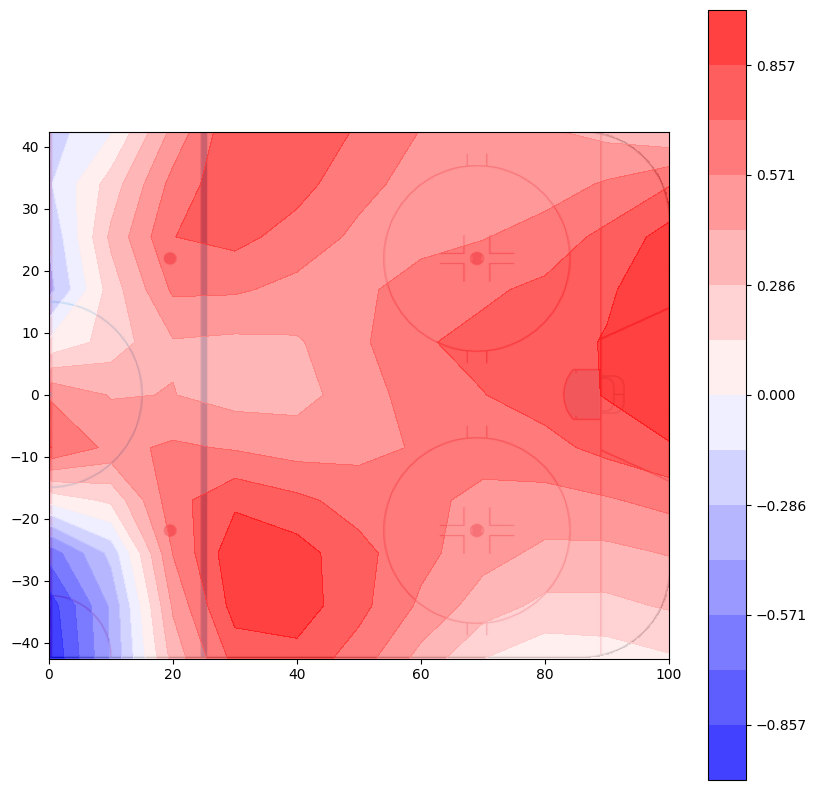

In [519]:

shots_hist2D_season, x_grid, y_grid = get_shots_hist2D(x_shots_season, y_shots_season, num_pts_x=10, num_pts_y=10)
shots_hist2D_season_by_hour = shots_hist2D_season / (number_of_games*2)

shots_hist2D_one_team, x_grid, y_grid = get_shots_hist2D(x_shots_one_team, y_shots_one_team, num_pts_x=10, num_pts_y=10)
shots_hist2D_one_team_by_hour = shots_hist2D_one_team / (number_of_games_by_team)

shots_hist2D_one_team_by_hour_s = gaussian_filter(shots_hist2D_one_team_by_hour, sigma = 1.1)
shots_hist2D_season_by_hour_s = gaussian_filter(shots_hist2D_season_by_hour, sigma = 1.1)

diff = (shots_hist2D_one_team_by_hour_s-shots_hist2D_season_by_hour_s) / shots_hist2D_season_by_hour_s
# diff = gaussian_filter(diff, sigma = 1.1)

# Not necessary
diff_min = diff.min()
diff_max = diff.max()
alpha = (-2./(diff_min-diff_max)) 
beta = (diff_min + diff_max) / (diff_min - diff_max)
diff_norm = alpha * diff + beta

rink_img = (255 * mpimg.imread("./figures/nhl_rink.png")).astype(int)
(h, w, c) = rink_img.shape
rink_half_img = rink_img[:, int(w/2):, :]
# rink_half_img = ndimage.rotate(rink_half_img, 90).astype(int)


fig = plt.figure(figsize=(10,10))
plt.contourf(x_grid, y_grid, diff_norm, alpha=0.8, cmap='bwr', levels = np.linspace(diff_norm.min(), diff_norm.max(), 15))
# plt.colorbar(orientation = 'vertical')
plt.colorbar(boundaries=np.linspace(-1, 1, 5))
# plt.clim(vmin = -1, vmax = 1)

plt.imshow(rink_half_img, extent=[0, 100,-42.5, 42.5])

# plt.contourf(y_grid, x_grid, diff_norm, alpha=0.8, cmap='bwr', levels = np.linspace(-1, 1, 20))




In [520]:
np.linspace(-1, 1, 10)

array([-1.        , -0.77777778, -0.55555556, -0.33333333, -0.11111111,
        0.11111111,  0.33333333,  0.55555556,  0.77777778,  1.        ])

In [521]:
shots_hist2D_season_by_hour.max()

1.978743068391867

In [522]:
np.sort(data_season_df['Team'].unique())

array(['Anaheim Ducks (ANA)', 'Arizona Coyotes (ARI)',
       'Boston Bruins (BOS)', 'Buffalo Sabres (BUF)',
       'Calgary Flames (CGY)', 'Carolina Hurricanes (CAR)',
       'Chicago Blackhawks (CHI)', 'Colorado Avalanche (COL)',
       'Columbus Blue Jackets (CBJ)', 'Dallas Stars (DAL)',
       'Detroit Red Wings (DET)', 'Edmonton Oilers (EDM)',
       'Florida Panthers (FLA)', 'Los Angeles Kings (LAK)',
       'Minnesota Wild (MIN)', 'Montréal Canadiens (MTL)',
       'Nashville Predators (NSH)', 'New Jersey Devils (NJD)',
       'New York Islanders (NYI)', 'New York Rangers (NYR)',
       'Ottawa Senators (OTT)', 'Philadelphia Flyers (PHI)',
       'Pittsburgh Penguins (PIT)', 'San Jose Sharks (SJS)',
       'St. Louis Blues (STL)', 'Tampa Bay Lightning (TBL)',
       'Toronto Maple Leafs (TOR)', 'Vancouver Canucks (VAN)',
       'Vegas Golden Knights (VGK)', 'Washington Capitals (WSH)',
       'Winnipeg Jets (WPG)'], dtype=object)

In [523]:
(shots_hist2D_season / (number_of_games*2)).max()

shots_hist2D_season, x_grid, y_grid = get_shots_hist2D(x_shots_season, y_shots_season, num_pts_x=15, num_pts_y=15)
shots_hist2D_season_by_hour = shots_hist2D_season / (number_of_games*2)
shots_hist2D_season_by_hour_s = gaussian_filter(shots_hist2D_season_by_hour, sigma = 1.5)

print(shots_hist2D_season_by_hour.max())

1.1478743068391868


(16, 16)


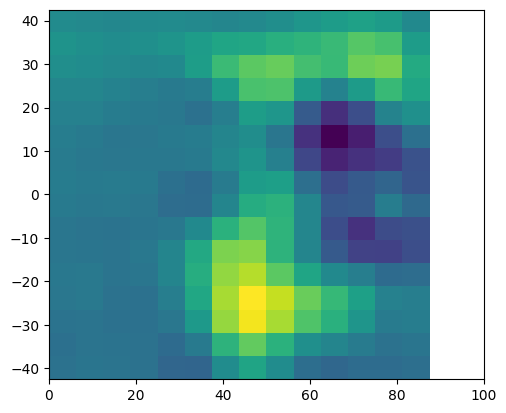

In [524]:
df_diff = pd.DataFrame(index=data_season_df['Team'].unique(), columns=['Diff'])

teams = data_season_df['Team'].unique()

for team in teams:

   data_one_team_df = data_season_df.loc[data_season_df['Team'] == team]

   x_shots_one_team = data_one_team_df['st_X'].to_numpy().copy().astype(np.float32)
   y_shots_one_team = data_one_team_df['st_Y'].to_numpy().copy().astype(np.float32)

   x_nan = np.isnan(x_shots_one_team)
   y_nan = np.isnan(y_shots_one_team)

   x_shots_one_team = x_shots_one_team[(~x_nan) & (~y_nan)]
   y_shots_one_team = y_shots_one_team[(~x_nan) & (~y_nan)]


   shots_hist2D_one_team, x_grid, y_grid = get_shots_hist2D(x_shots_one_team, y_shots_one_team, num_pts_x=15, num_pts_y=15)
   shots_hist2D_one_team_by_hour = shots_hist2D_one_team / (number_of_games_by_team)

   diff = gaussian_filter(shots_hist2D_one_team_by_hour-shots_hist2D_season_by_hour, 1.)
   # diff = (shots_hist2D_one_team_by_hour_s-shots_hist2D_season_by_hour_s) / shots_hist2D_season_by_hour_s

   diff_min = diff.min()
   diff_max = diff.max()
   alpha = (-2./(diff_min-diff_max)) 
   beta = (diff_min + diff_max) / (diff_min - diff_max)
   diff_norm = alpha * diff + beta

   mask = np.where(x_grid > 89)
   diff_norm[:, mask] = 0
   df_diff.loc[team]['Diff'] = diff_norm

df_diff = df_diff.sort_index()

print(df_diff.iloc[0]['Diff'].shape)

mask = np.where(x_grid > 89)
diff_norm[:, mask] = None

plt.imshow(diff_norm, extent=[x_grid[0], x_grid[-1], y_grid[0], y_grid[-1]])





In [525]:
num_pts_x=40
num_pts_y=20

shots_hist2D_season, x_grid, y_grid = get_shots_hist2D(x_shots_season, y_shots_season, num_pts_x=num_pts_x, num_pts_y=num_pts_y)
shots_hist2D_season_by_hour = shots_hist2D_season / (number_of_games*2)

dict_diff = {}

teams = np.sort(data_season_df['Team'].unique())

for team in teams:

   data_one_team_df = data_season_df.loc[data_season_df['Team'] == team]

   x_shots_one_team = data_one_team_df['st_X'].to_numpy().copy().astype(np.float32)
   y_shots_one_team = data_one_team_df['st_Y'].to_numpy().copy().astype(np.float32)

   x_nan = np.isnan(x_shots_one_team)
   y_nan = np.isnan(y_shots_one_team)

   x_shots_one_team = x_shots_one_team[(~x_nan) & (~y_nan)]
   y_shots_one_team = y_shots_one_team[(~x_nan) & (~y_nan)]


   shots_hist2D_one_team, x_grid, y_grid = get_shots_hist2D(x_shots_one_team, y_shots_one_team, num_pts_x=num_pts_x, num_pts_y=num_pts_y)
   shots_hist2D_one_team_by_hour = shots_hist2D_one_team / (number_of_games_by_team)

   diff = gaussian_filter(shots_hist2D_one_team_by_hour-shots_hist2D_season_by_hour, 1.)
   # diff = (shots_hist2D_one_team_by_hour_s-shots_hist2D_season_by_hour_s) / shots_hist2D_season_by_hour_s

   diff_min = diff.min()
   diff_max = diff.max()
   alpha = (-2./(diff_min-diff_max)) 
   beta = (diff_min + diff_max) / (diff_min - diff_max)
   diff_norm = alpha * diff + beta

   mask = np.where(x_grid > 89)
   diff_norm[:, mask] = None
   dict_diff[team] = diff_norm

In [526]:
list(dict_diff.values())[0].shape

(21, 41)

In [527]:
shots_hist2D_season_by_hour.min()

0.0

In [528]:
df_diff90 = df_diff.copy()
df_diff90['Diff'] = df_diff90['Diff'].apply(np.rot90)
print(df_diff90.head())
print(df_diff.head())

                                                                    Diff
Anaheim Ducks (ANA)    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
Arizona Coyotes (ARI)  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
Boston Bruins (BOS)    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
Buffalo Sabres (BUF)   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
Calgary Flames (CGY)   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
                                                                    Diff
Anaheim Ducks (ANA)    [[0.1880013050683817, 0.18581044013380454, 0.1...
Arizona Coyotes (ARI)  [[-0.01875874547486625, -0.09776722069614259, ...
Boston Bruins (BOS)    [[-0.04222329926616378, 0.01918814245465851, 0...
Buffalo Sabres (BUF)   [[0.09036823673647196, 0.10096120240294931, 0....
Calgary Flames (CGY)   [[-0.3458871930009794, -0.3371022827956487, -0...


In [529]:
print(df_diff.iloc[0]['Diff'].sum())

38.341306756977886


In [532]:
import plotly.graph_objects as go
import plotly.express as px

import pandas as pd
from PIL import Image

# load dataset

# Create figure
fig = go.Figure()


rink_img = Image.open("./figures/nhl_rink.png")
width, height = rink_img.size
rink_half_img = rink_img.crop((width/2, 0, width, height))

# rink_half_img = rink_half_img.rotate(90, expand=1)
# _, x_grid, y_grid = get_shots_hist2D(x_shots_season, y_shots_season, num_pts_x=15, num_pts_y=15)
# (x_grid90, y_grid90) = (-y_grid, 100-x_grid)
# df_diff90 = df_diff.copy()
# df_diff90['Diff'] = df_diff90['Diff'].apply(np.rot90)

# Constants
img_width = 1000
img_height = 500
scale_factor = 1.0

fig.add_trace(
    go.Contour(
        z=list(dict_diff.values())[0],
        x=x_grid,
        y=y_grid,
        colorscale="Rdbu", 
        reversescale=True,
        connectgaps=False,
        opacity=0.5,
        contours=dict(
            start=-1,
            end=1,
            size=0.2,
        )
    )
)


# fig.add_trace(
#     px.density_contour(
#         list(dict_diff.values())[0],
#         x=x_grid,
#         y=y_grid,
#     )
# )



updatemenu = []
buttons=[]
for team in df_diff.index.to_list():
    buttons.append(dict(method='restyle',
                        label=team,
                        args=[{
                            #    'z':[df_diff.loc[team]['Diff']],
                               'z':[dict_diff[team]],
                               'type': 'contour'}, [0]])
 
                  )

fig.add_layout_image(
    dict(
        x=0,
        sizex=100,
        y=42.5,
        sizey=42.5*2,
        xref="x",
        yref="y",
        opacity=1.0,
        layer="below",
        sizing="stretch",
        source=rink_half_img)
)

fig.update_layout(
    width=img_width * scale_factor,
    height=img_height * scale_factor,
    margin={"l": 20, "r": 20, "t": 50, "b": 20},
    #source=rink_half_img
)

fig.update_xaxes(
    # autorange="reversed",
    showgrid=False,
    range=[0, 100])

fig.update_yaxes(
    # visible=True,
    # showgrid=False,
    # autorange="reversed",
    range=[-42.5, 42.5])               




updatemenu=[]
your_menu=dict()
updatemenu.append(your_menu)
updatemenu[0]['buttons']=buttons
updatemenu[0]['direction']='down'
updatemenu[0]['showactive']=True

# update layout and show figure
fig.update_layout(
    title={
        'text': f'Shots Heatmap os Season {season_year}/{season_year+1}',
        'y':0.95,
        'x':0.6,
        'xanchor': 'center',
        'yanchor': 'top'},
    xaxis_title='Distance from center line (ft.)',
    yaxis_title='Distance from center of rink (ft.)',
    updatemenus=updatemenu)


fig.show()

fig.write_html(f'../blogpost/_includes/season_{season_year}_{season_type}.html')


ValueError: 
    Invalid value of type 'builtins.dict' received for the 'colorscale' property of contour
        Received value: {'title': 'coco'}

    The 'colorscale' property is a colorscale and may be
    specified as:
      - A list of colors that will be spaced evenly to create the colorscale.
        Many predefined colorscale lists are included in the sequential, diverging,
        and cyclical modules in the plotly.colors package.
      - A list of 2-element lists where the first element is the
        normalized color level value (starting at 0 and ending at 1),
        and the second item is a valid color string.
        (e.g. [[0, 'green'], [0.5, 'red'], [1.0, 'rgb(0, 0, 255)']])
      - One of the following named colorscales:
            ['aggrnyl', 'agsunset', 'algae', 'amp', 'armyrose', 'balance',
             'blackbody', 'bluered', 'blues', 'blugrn', 'bluyl', 'brbg',
             'brwnyl', 'bugn', 'bupu', 'burg', 'burgyl', 'cividis', 'curl',
             'darkmint', 'deep', 'delta', 'dense', 'earth', 'edge', 'electric',
             'emrld', 'fall', 'geyser', 'gnbu', 'gray', 'greens', 'greys',
             'haline', 'hot', 'hsv', 'ice', 'icefire', 'inferno', 'jet',
             'magenta', 'magma', 'matter', 'mint', 'mrybm', 'mygbm', 'oranges',
             'orrd', 'oryel', 'oxy', 'peach', 'phase', 'picnic', 'pinkyl',
             'piyg', 'plasma', 'plotly3', 'portland', 'prgn', 'pubu', 'pubugn',
             'puor', 'purd', 'purp', 'purples', 'purpor', 'rainbow', 'rdbu',
             'rdgy', 'rdpu', 'rdylbu', 'rdylgn', 'redor', 'reds', 'solar',
             'spectral', 'speed', 'sunset', 'sunsetdark', 'teal', 'tealgrn',
             'tealrose', 'tempo', 'temps', 'thermal', 'tropic', 'turbid',
             'turbo', 'twilight', 'viridis', 'ylgn', 'ylgnbu', 'ylorbr',
             'ylorrd'].
        Appending '_r' to a named colorscale reverses it.


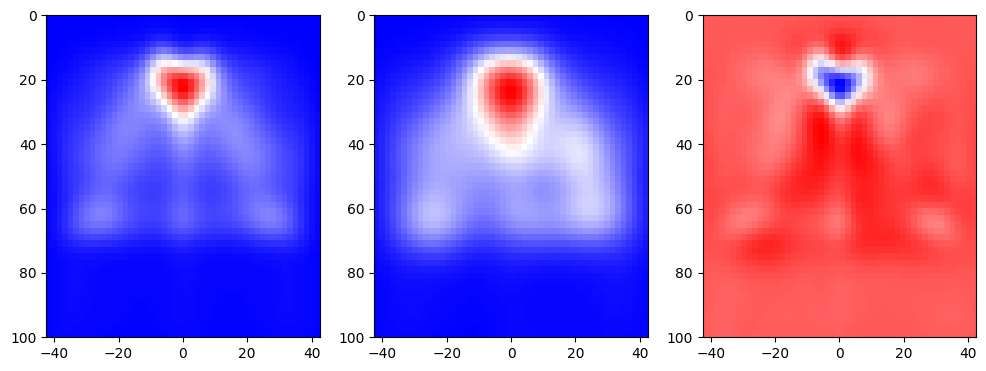

In [531]:
y_min, y_max = -42.5, 42.5
x_min, x_max = 0, 100


def get_kde(x_shots, y_shots):

   X, Y = np.mgrid[x_min:x_max:50j, y_min:y_max:50j]
   positions = np.vstack([X.ravel(), Y.ravel()])
   values = np.vstack([x_shots, y_shots])
   kernel = stats.gaussian_kde(values)
   Z = np.reshape(kernel(positions).T, X.shape)
   return Z

fig, ax = plt.subplots(1, 3, figsize=(12, 12))

kde_season = get_kde(x_shots_season, y_shots_season)
ax[0].imshow(kde_season, cmap='bwr', extent=[y_min, y_max, x_min, x_max])
# ax[0].plot(y_shots_season, x_shots_season, 'k.', markersize=2)
ax[0].set_xlim([y_min, y_max])
ax[0].set_ylim([x_max, x_min])

kde_team = get_kde(x_shots_one_team, y_shots_one_team)
ax[1].imshow(kde_team, cmap='bwr', extent=[y_min, y_max, x_min, x_max])
# ax[1].plot(y_shots_one_team, x_shots_one_team, 'k.', markersize=2)
ax[1].set_xlim([y_min, y_max])
ax[1].set_ylim([x_max, x_min])

kde_diff = (kde_team - kde_season) 
ax[2].imshow(kde_diff, cmap='bwr', extent=[y_min, y_max, x_min, x_max])
# ax[2].plot(y_shots_one_team, x_shots_one_team, 'k.', markersize=2)
ax[2].set_xlim([y_min, y_max])
ax[2].set_ylim([x_max, x_min])
plt.show()


In [462]:
kde_diff.max()

0.00011486444269929118

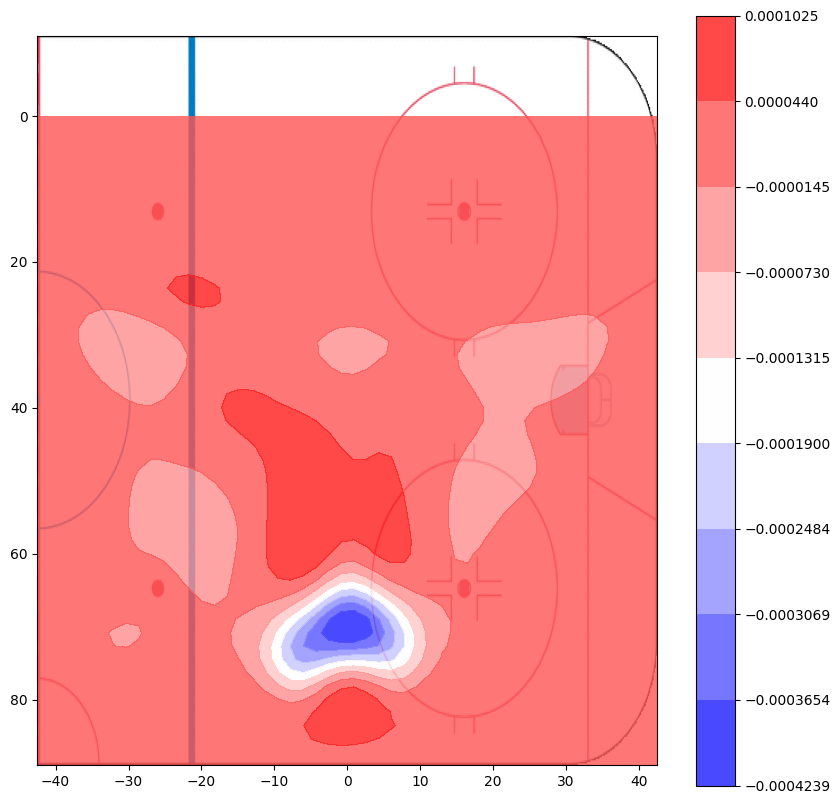

In [402]:
x_min, x_max = 0, 89
y_min, y_max = -42.5, 42.5

y_grid, x_grid = np.mgrid[x_min:x_max:50j, y_min:y_max:50j]

fig = plt.figure(figsize=(10,10))
# plt.contourf(x_grid, y_grid, kde_season, alpha=0.8, cmap='bwr', levels = np.linspace(kde_season.min(), kde_season.max(), 10), vmin=kde_season.min(), vmax=kde_season.max())
plt.contourf(x_grid, y_grid, kde_diff, alpha=0.8, cmap='bwr', levels = np.linspace(kde_diff.min(), kde_diff.max(), 10), vmin=kde_diff.min(), vmax=kde_diff.max())
plt.colorbar(orientation = 'vertical')
plt.imshow(rink_half_img, extent=[-42.5, 42.5, 89, -11])